In [138]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [139]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import mean
import matplotlib.pyplot as plt

# Ініціалізуємо SparkSession
spark = SparkSession.builder \
    .appName("Book Dataset Analysis") \
    .getOrCreate()

# -1- Прочитайте CSV файл spark.read.csv() 
df = spark.read.csv("bestsellers with categories.csv", header=True, inferSchema=True)

# -2- Вивести схему даних за допомогою PrintSchema 
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- User Rating: double (nullable = true)
 |-- Reviews: integer (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Genre: string (nullable = true)



In [140]:
# -3- Вивести назви стовпців і типи даних за допомогою dtypes

df.dtypes

[('Name', 'string'),
 ('Author', 'string'),
 ('User Rating', 'double'),
 ('Reviews', 'int'),
 ('Price', 'int'),
 ('Year', 'int'),
 ('Genre', 'string')]

In [141]:
# -4- Виведіть перші п'ять рядків (використовується метод head)
df.head(5)

[Row(Name='10-Day Green Smoothie Cleanse', Author='JJ Smith', User Rating=4.7, Reviews=17350, Price=8, Year=2016, Genre='Non Fiction'),
 Row(Name='11/22/63: A Novel', Author='Stephen King', User Rating=4.6, Reviews=2052, Price=22, Year=2011, Genre='Fiction'),
 Row(Name='12 Rules for Life: An Antidote to Chaos', Author='Jordan B. Peterson', User Rating=4.7, Reviews=18979, Price=15, Year=2018, Genre='Non Fiction'),
 Row(Name='1984 (Signet Classics)', Author='George Orwell', User Rating=4.7, Reviews=21424, Price=6, Year=2017, Genre='Fiction'),
 Row(Name='5,000 Awesome Facts (About Everything!) (National Geographic Kids)', Author='National Geographic Kids', User Rating=4.8, Reviews=7665, Price=12, Year=2019, Genre='Non Fiction')]

In [142]:
# -5- Вивести перший рядок за допомогою first() 
df.first()

Row(Name='10-Day Green Smoothie Cleanse', Author='JJ Smith', User Rating=4.7, Reviews=17350, Price=8, Year=2016, Genre='Non Fiction')

In [143]:
# -6- Зробіть опис датасету за допомогою describe()
df.describe()

DataFrame[summary: string, Name: string, Author: string, User Rating: string, Reviews: string, Price: string, Year: string, Genre: string]

In [144]:
# -7- Виведіть список стовпців за допомогою columns() 
df.columns

['Name', 'Author', 'User Rating', 'Reviews', 'Price', 'Year', 'Genre']

In [145]:
# -8- Виведіть загальну кількість рядків даних за допомогою count() 
print("Total rows:", df.count())

Total rows: 550


In [146]:
# -9- Перевірте, чи у всіх рядків вистачає даних. Якщо є пропуски, замінить їх на NaN, потім тип даних на числовий.
df = df.select([when(isnan(c) | col(c).isNull(), float('nan')).otherwise(col(c)).alias(c) for c in df.columns])

In [147]:
# -10- Замініть комірки з пропущеними значенями на середні за стовпцем. І тип даних на float.
for col_name in df.columns:
    mean_value = df.select(mean(col_name)).collect()[0][0]
    df = df.withColumn(col_name, when(col(col_name).isNull(), mean_value).otherwise(col(col_name)))
    df = df.withColumn(col_name, col(col_name).cast("float"))


In [148]:
# -11- Змініть назви всіх колонок: назва з маленької букви, без пробілів через підкреслення.
df = df.withColumnRenamed('Name', 'name') \
       .withColumnRenamed('Author', 'author') \
       .withColumnRenamed('User Rating', 'user_rating') \
       .withColumnRenamed('Reviews', 'reviews') \
       .withColumnRenamed('Price', 'price') \
       .withColumnRenamed('Year', 'year') \
       .withColumnRenamed('Genre', 'genre')

In [149]:
# -12- Знайдіть автора з найвищим рейтингом
max_rating_author = df.orderBy(col("user_rating").desc()).select("author").first()[0]
print("Автор з найвищим рейтингом:", max_rating_author)

Автор з найвищим рейтингом: Bill Martin Jr.


In [150]:
# -13- Знайдіть автора з найнижчим рейтингом
min_rating_author = df.orderBy(col("user_rating")).select("author").first()[0]
print("Автор з найнижчим рейтингом:", min_rating_author)

Автор з найнижчим рейтингом: J.K. Rowling


In [151]:
# -14- Знайдіть автора, що має найбільшу кількіть рецензій
max_reviews_author = df.orderBy(col("reviews").desc()).select("author").first()[0]
print("Автор з найбільшою кількістю рецензій:", max_reviews_author)


Автор з найбільшою кількістю рецензій: Delia Owens


C:\Users\dimas\AppData\Local\Temp\ipykernel_13944\2342853977.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


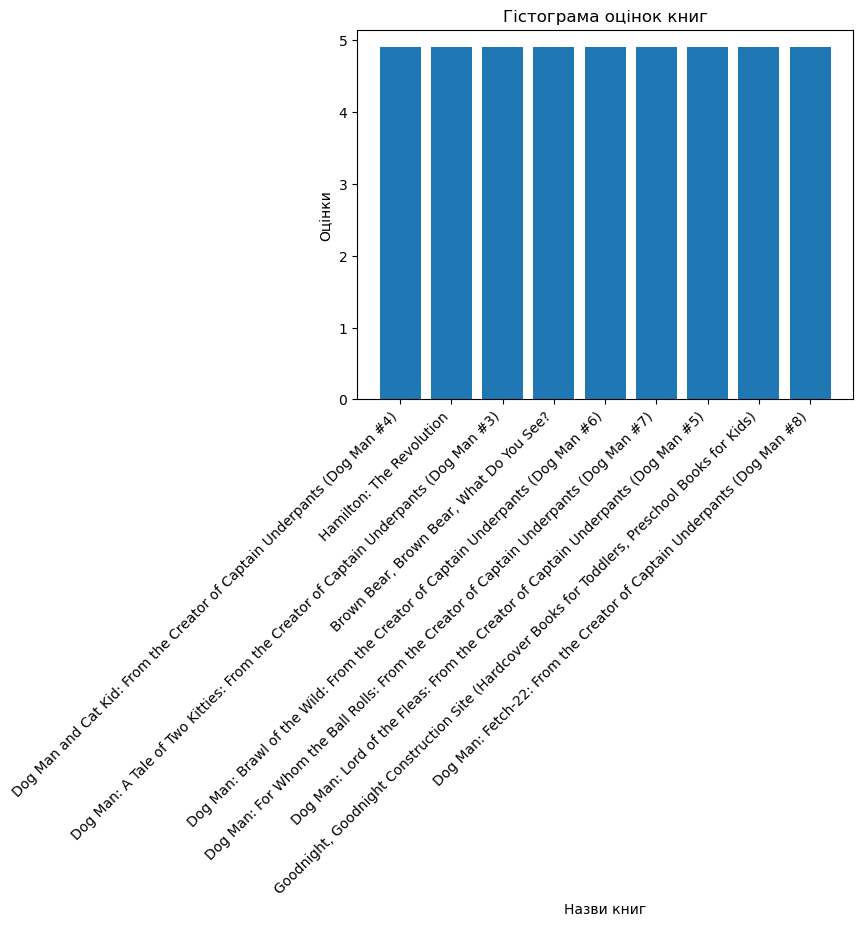

In [152]:
# -15- Побудуйте гістограму рейтингу 10 найкращих книг (відібрати книги з найбільшим рейтингом).
top_10_books = df.orderBy(df["user_rating"].desc()).head(10)

book_names = [book[0] for book in top_10_books]
ratings = [book[2] for book in top_10_books]

plt.bar(book_names, ratings)
plt.xlabel('Назви книг')
plt.ylabel('Оцінки')
plt.title('Гістограма оцінок книг')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [153]:
# -16- Побудуйте матрицю кореляції для стовпчиків 'user_rating', 'reviews', 'price'
correlation_matrix = df.select('user_rating', 'reviews', 'price').toPandas().corr()
print("Матриця кореляції:")
print(correlation_matrix)

Матриця кореляції:
             user_rating   reviews     price
user_rating     1.000000 -0.001729 -0.133086
reviews        -0.001729  1.000000 -0.109182
price          -0.133086 -0.109182  1.000000


**ВИСНОВОК:** на лабораторній роботі я продовжив вивчати мову програмування Python, зокрема бібліотеку pyspark. На лабораторній роботі я виконував дослідження датасету та різні можливості бібліотеки pyspark